In [1]:
import numpy as np
import pandas as pd
#load dataset
dataframe = pd.read_table("housing.data.txt",delim_whitespace=True, header=None )

In [2]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
dataset = dataframe.values
#split into input(x) i.e. predictor and output(y) i.e. response 
X = dataset[:,0:13]
Y = dataset[:,13]

In [4]:
# create training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2) 
#stardardizing
scaler = StandardScaler().fit(X_train)
std_X_train = scaler.transform(X_train)
# also standardize xtest
scaler2 = StandardScaler().fit(X_test)
std_X_test = scaler2.transform(X_test)

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

In [6]:
# fit a simple model first
gbrt = GradientBoostingRegressor(n_estimators=100)
gbrt.fit(std_X_train, Y_train)
y_pred = gbrt.predict(std_X_test)

In [21]:
#printg R squared value for train/test. 
# explains how much of the variance in the data our model is able to decipher.
print('R squared for training set: ', gbrt.score(std_X_train,Y_train))
print('R squared for testing set: ', gbrt.score(std_X_test,Y_test))

R squared for training set:  0.9804940532132591
R squared for testing set:  0.8425397954481073


In [27]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [28]:
# hyperparameters are extremely critical to the model. 
#Now, if we tune parameters against the Test dataset, we will end up biasing towards the test set and will once again #not generalize very well. We will also have no good way to find out since we have essentially trained on all our data. 
#Luckily scikit-learn has builit-in packages that can help with this. 
# We'll use a crossvalidation generator that can train the model by tuning the parameters based on a cross-validation subset (cv) that is picked from within the training set.
# A different cv subset will be picked for each iteration, we control the number of iterations. 
# Then we will use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters 
#to give us the best parameter that gives the optimal result. 
    
#Defining this as a function so we can call it anytime we want 


def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor()
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
    #for each iteration. There are other methods like the KFold split.
    
    #n_splits controls number of re-shuffling/iterations
    cv = ShuffleSplit(n_splits=10, test_size=0.2)
    
    #Apply the cross-validation iterator on the Training set using GridSearchCV. 
    # This will run the classifier on the different train/cv splits using parameters specified and return the model that has the best results.
    
    classifier = GridSearchCV(estimator = estimator, cv=cv, param_grid = param_grid)
    
    #fit the training dataset to this classifier
    classifier.fit(std_X_train,Y_train)
    
    #printing results
    print('Best estimator learned through GridSearch')
    print(classifier.best_estimator_)
    
    return cv, classifier.best_estimator_

In [29]:
#Below is a plot_learning_curve module that's provided by scikit-learn. It allows us to quickly and easily visualize how 
#well the model is performing based on number of samples we're training on. It helps to understand situations such as 
#high variance or bias.

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """ Generate a simple plot of the test and traning learning curve. 
    Parameters ---------- 
    estimator : object type that implements the "fit" and "predict" methods.
    An object of that type which is cloned for each validation. 
    title : string Title for the chart. 
    X : array-like, shape (n_samples, n_features) 
    Training vector, where n_samples is the number of samples and n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), 
    optional Target relative to X for classification or regression; None for unsupervised learning. 
    ylim : tuple, shape (ymin, ymax), optional 
    Defines minimum and maximum yvalues plotted. 
    cv : integer, cross-validation generator, optional 
    If an integer is passed, it is the number of folds (defaults to 3). 
    Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects 
    n_jobs : integer, optional Number of jobs to run in parallel (default 1). """ 
    
    
    plt.figure() #Create figure (?)
    plt.title(title) #Give title to plot
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    #call learning_curve function - see documetation for further details
    train_sizes, train_scores, test_scores = learning_curve(estimator, X,y, cv=cv, n_jobs = n_jobs, train_sizes = train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")
    
    plt.legend(loc='best')
    
    return plt

In [39]:
param_grid = {'n_estimators':[100,200], 
              'learning_rate' :[0.08,0.05,0.02], 
              'max_depth':[8,6,4],
              'min_samples_leaf':[5,8],
              'max_features':[0.8,0.5]} 

n_jobs=1

cv,best_est = GradientBooster(param_grid, n_jobs)

Best estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=8,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [40]:
print('Best Estimator Parameters')
print('------------')
print ("n_estimators: " ,best_est.n_estimators)
print ("max_depth: ", best_est.max_depth)
print ("Learning Rate: ", best_est.learning_rate)
print ("min_samples_leaf: ", best_est.min_samples_leaf)
print ("max_features: " ,best_est.max_features)

print("Training R-squared: ", best_est.score(std_X_train,Y_train))

Best Estimator Parameters
------------
n_estimators:  200
max_depth:  4
Learning Rate:  0.05
min_samples_leaf:  8
max_features:  0.5
Training R-squared:  0.9827692316102734


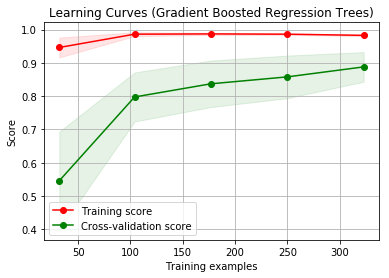

In [41]:
#OK we'll now call the plot_learning_curve module by feeding it the estimator (best estimator returned from GS) #and train/cv sets. 
#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores.
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now. 
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely)


title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, 
                                      max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, 
                                      min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, std_X_train, Y_train, cv=cv, n_jobs=n_jobs) #use cv and n_jobs from above
plt.show()

In [42]:
estimator = best_est

In [43]:
estimator.fit(std_X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=8,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
#Test R-squared using best estimator
print("Test set R-squared: ", estimator.score(std_X_test,Y_test))

Test set R-squared:  0.8280262404402408


In [45]:
predictions = estimator.predict(std_X_test)

In [47]:
df_result =pd.concat([pd.DataFrame(Y_test), pd.DataFrame(predictions)], axis=1)
df_result.columns =['Y_test','Predicted']
df_result

,Y_test,Predicted
0,18.5,16.872950
1,11.9,11.709831
2,18.2,20.054272
3,28.4,28.617714
4,31.6,29.606903
5,23.6,24.675014
6,17.3,15.068441
7,13.8,9.830395
8,19.4,21.281735
9,29.4,27.908432


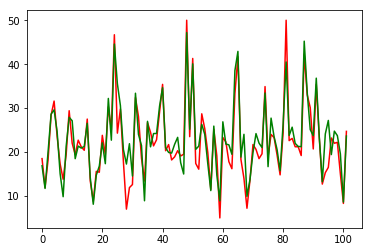

In [50]:
plt.plot(np.arange(102),Y_test,color='r')
plt.plot(np.arange(102),predictions,color='g')

In [52]:
#Calculate the feature ranking - top 5
importances = estimator.feature_importances_
index = np.argsort(importances) #return indices that sorts
index

array([ 1,  3,  8,  2,  9, 10,  4,  6,  0, 11, 12,  5,  7], dtype=int64)

In [54]:
estimator.feature_importances_

array([0.07655866, 0.00315499, 0.03107055, 0.00512301, 0.0736248 ,
       0.1734985 , 0.07433155, 0.19636194, 0.01323419, 0.04143863,
       0.0487783 , 0.09796515, 0.16485975])

In [60]:
dataframe.columns=['A','B','C','D','E','F','G','H','I','J',"K",'L','M','target']
dataframe.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [62]:
indices2= index[::-1] #reverse the array of indices
indices2

array([ 7,  5, 12, 11,  0,  6,  4, 10,  9,  2,  8,  3,  1], dtype=int64)

In [68]:
print("Top 5 Important Features\n")
for i in range(5):
    print('{} ({})'.format(dataframe.columns[indices2[i]], importances[indices2[i]]))

Top 5 Important Features

H (0.19636194193921455)
F (0.17349850248803228)
M (0.16485974606398415)
L (0.09796514890182455)
A (0.07655865580192706)
